Import libraries and data

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

with pd.HDFStore('MiningProcess_Flotation_Plant_Database_train_split.h5') as store:
    X_cal = store.get('X_cal')
    Y_cal = store.get('Y_cal')
    X_test = store.get('X_test')
    Y_test = store.get('Y_test')

R2 variable selection function

In [26]:
def pls_r2_variable_selection(X, y, V):
    """
    Perform R2 score-based variable selection for PLS.
    
    Parameters:
    X : numpy array, shape (n_samples, n_features)
        The input data matrix.
    y : numpy array, shape (n_samples,)
        The target variable.
    V : int
        The desired number of variables to be selected.
    
    Returns:
    s : list
        Indices of the selected features, sorted by selection order.
    """

    
    n, m = X.shape
    s = []  # Selected variables
    s_names= []
    R2_out = []
    sn = list( X.columns.values )  # Unselected variables
    N = 0  # Number of selected variables
    M = m  # Number of unselected variables
    
    X = X.values
    y = y.values
    
    # Standardize X and y
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    for v in tqdm( range(V) ):
        TSS = np.sum((y_scaled - np.mean(y_scaled))**2)
        R2_values = []
        
        for i, m in enumerate(sn):
            s_temp = s + [i]
            X_temp = X_scaled[:, s_temp]
            
            # Calibrate PLS model
            pls = PLSRegression(n_components=min(len(s_temp), 4))  # Limit components to avoid overfitting
            pls.fit(X_temp, y_scaled)
            
            # Estimate y from the model
            y_pred = pls.predict(X_temp).flatten()
            
            # Calculate RSS and R2
            RSS = np.sum((y_scaled - y_pred)**2)
            R2 = 1 - RSS / TSS
            # print( R2 )
            R2_values.append(R2)
        
        # Select the variable with the highest R2
        idx = np.argmax(R2_values)
        R2_out.append(R2_values[idx])
        s.append(idx)
        s_names.append(sn[idx])
        sn.pop(idx)
        N += 1
        M -= 1
    
    return s, np.array(R2_out), s_names


Running the variable selection

In [27]:
V = 100     # Number of variables
selected_features, R2_values, s_names = pls_r2_variable_selection(X_cal, Y_cal, V)

100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


[np.int64(21), np.int64(23), np.int64(106), np.int64(22), np.int64(24), np.int64(49), np.int64(1), np.int64(26), np.int64(89), np.int64(41), np.int64(14), np.int64(86), np.int64(38), np.int64(67), np.int64(14), np.int64(1), np.int64(29), np.int64(21), np.int64(86), np.int64(1), np.int64(21), np.int64(18), np.int64(81), np.int64(35), np.int64(29), np.int64(15), np.int64(73), np.int64(30), np.int64(21), np.int64(18), np.int64(40), np.int64(48), np.int64(33), np.int64(59), np.int64(15), np.int64(26), np.int64(21), np.int64(16), np.int64(42), np.int64(15), np.int64(43), np.int64(67), np.int64(45), np.int64(32), np.int64(21), np.int64(17), np.int64(14), np.int64(44), np.int64(14), np.int64(59), np.int64(14), np.int64(44), np.int64(13), np.int64(29), np.int64(14), np.int64(44), np.int64(14), np.int64(1), np.int64(14), np.int64(42), np.int64(14), np.int64(42), np.int64(13), np.int64(1), np.int64(14), np.int64(43), np.int64(14), np.int64(10), np.int64(1), np.int64(14), np.int64(16), np.int64(1

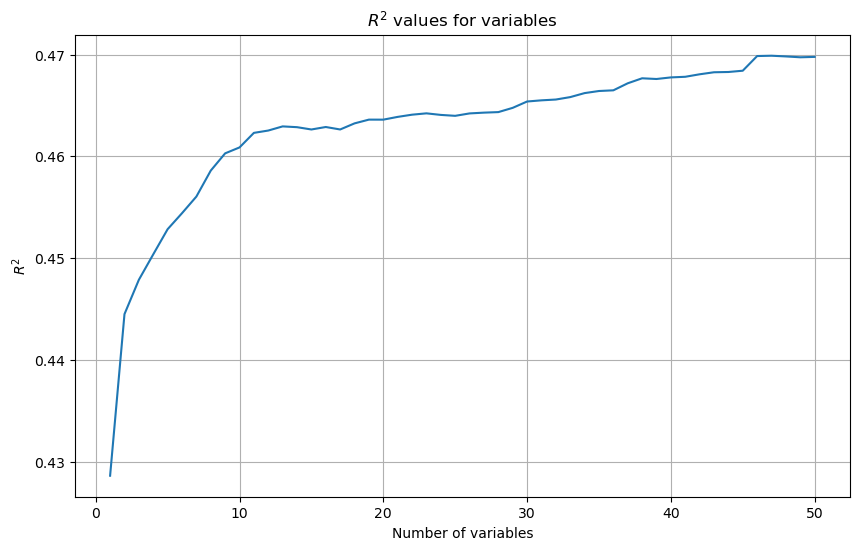

In [29]:
fig = plt.figure(figsize=(10, 6))
plt.plot( range(1, 51), R2_values[:50], "-" )
plt.grid()
plt.title( r"$R^2$ values for variables" )
plt.ylabel( r"$R^2$" )
plt.xlabel( "Number of variables" )

print( selected_features )

X_cal.columns[selected_features]


df = pd.DataFrame({'Column':s_names,'Cumulative R2':R2_values})

In [34]:
df.to_csv('variables.csv')